# Background 
A very common pattern in data analysis is to do "Named Entity Recognition". This is where a team builds a model to idenify key elements out of text for later processing. For example:

“Mark Zuckerberg is one of the founders of Facebook, a company from the United States” 

Out of this sentance, a model may produce:
- "Mark Zuckerberg" - Two word phrase describing a person
- "Facebook" - Company, related to Mark Zuckerberg in some way
- "United States" - Location, related to Mark Zuckerberg & Facebook in some way

More advanced models could draw some further association using nouns and verbs, but even this level of analysis offers a good deal of information to search engines, content correlation, categorization, etc.

# Doing Named Entity Recognition on Medical Journals

A new effort for automated analysis of text is using Named Entity Recognition techniques on existing and newly published content to enable faster analysis. In areas where there are too many publications for humans to read regularly, this unlocks far more knowledge quickly.

For example, in medical journals, many thousands of articles are published every month, and there are over 25 million historical papers as well - far more than any organization could process. Using a named entity recognition tool will enable fast searching, analysis of associated papers and potential information for further investigation.

The example we will look at is a simplified version of this one - 
- https://nbviewer.jupyter.org/github/andressotov/Named-Entity-Recognition-in-French-biomedical-text/blob/master/Named%20Entity%20Recognition%20in%20French%20biomedical%20text.ipynb 
- https://nbviewer.jupyter.org/github/andressotov/Named-Entity-Recognition-in-French-biomedical-text/blob/master/Named%20Entity%20Recognition%20in%20French%20biomedical%20text%20Part%202.ipynb

# Step 1 - Ingest the data from flat files

In [1]:
# path to the data train set 
path_train = "corpus/dev/MEDLINE"

def read_file(path,file,ext):    
    f = path+'/'+file+ext
    with open(f, 'rt', encoding='utf-8') as myfile:
        data = myfile.readlines()
    return data

# To read a file and obtain its content
data = read_file(path_train,"2787",".txt")
data

["Glutamine synthétase et glutamine gamma-glutamyl transferase dans le rein de l' homme , du chien et du rat\n"]

# Step 2 - Print out the data to make sure it's being read properly

In [2]:
import pprint

data = read_file(path_train,"2787",".ann")
pprint.pprint(data)

['T1\tCHEM 0 20\tGlutamine synthétase\n',
 '#1\tAnnotatorNotes T1\tC0017801\n',
 'T2\tCHEM 0 9\tGlutamine\n',
 '#2\tAnnotatorNotes T2\tC0017797\n',
 'T3\tCHEM 10 20\tsynthétase\n',
 '#3\tAnnotatorNotes T3\tC0023689\n',
 'T4\tCHEM 24 33\tglutamine\n',
 '#4\tAnnotatorNotes T4\tC0017797\n',
 'T5\tCHEM 34 60\tgamma-glutamyl transferase\n',
 '#5\tAnnotatorNotes T5\tC0017040\n',
 'T6\tCHEM 49 60\ttransferase\n',
 '#6\tAnnotatorNotes T6\tC0040676\n',
 'T7\tANAT 69 73\trein\n',
 '#7\tAnnotatorNotes T7\tC0022646\n',
 'T8\tLIVB 80 85\thomme\n',
 '#8\tAnnotatorNotes T8\tC0086418\n',
 'T9\tLIVB 91 96\tchien\n',
 '#9\tAnnotatorNotes T9\tC0012984\n',
 'T10\tLIVB 103 106\trat\n',
 '#10\tAnnotatorNotes T10\tC0034721\n']


# Step 3 - Convert from .ann File Type to a Dict

In [3]:
def ann_text2dict(lines):
    d = {}
    for l in lines:
        if not l.startswith('#'):
            t = l.split('\t')
            if ';' in t[1]:
                t[1] = t[1].replace(';',' ; ')
            d[t[0]] = {
                'label':t[1].split(' '),
                'text':t[2].replace('\n','')
            }
    return d
d = ann_text2dict(data)
pprint.pprint(d)

{'T1': {'label': ['CHEM', '0', '20'], 'text': 'Glutamine synthétase'},
 'T10': {'label': ['LIVB', '103', '106'], 'text': 'rat'},
 'T2': {'label': ['CHEM', '0', '9'], 'text': 'Glutamine'},
 'T3': {'label': ['CHEM', '10', '20'], 'text': 'synthétase'},
 'T4': {'label': ['CHEM', '24', '33'], 'text': 'glutamine'},
 'T5': {'label': ['CHEM', '34', '60'], 'text': 'gamma-glutamyl transferase'},
 'T6': {'label': ['CHEM', '49', '60'], 'text': 'transferase'},
 'T7': {'label': ['ANAT', '69', '73'], 'text': 'rein'},
 'T8': {'label': ['LIVB', '80', '85'], 'text': 'homme'},
 'T9': {'label': ['LIVB', '91', '96'], 'text': 'chien'}}


# Step 4 - Combine .txt and .ann files into a Single Dict

In [4]:
import os
import pickle

def save_pickle(data,file):
    pick_file = open(file+".pkl", "wb")
    pickle.dump(data, pick_file)
    pick_file.close()

def load_pickle(file):
    pick_file = open(file+".pkl", "rb")
    data = pickle.load(pick_file)
    pick_file.close()
    return data

def collect_files(path,set):
    dirs = os.listdir(path)
    ltxt = []
    lann = []
    for f in dirs:
        if f.endswith('.txt'):
            f = f.replace('.txt','')
            ltxt.append(f)
        elif f.endswith('.ann'):
            f = f.replace('.ann','')
            lann.append(f)
        else:
            pass
    save_pickle(ltxt,set+'_txt')
    save_pickle(lann,set+'_ann')
    
collect_files(path_train,'train')

# Step 5 - Process the Text in .ann Files into a Dict

In [5]:
def ann_files2dict(pic_file,path,set):
    lann = load_pickle(pic_file)
    lnew = []
    c = 0
    for ann in lann:
        data = read_file(path, ann, ".ann")
        dic = ann_text2dict(data)
        c+=1
        lnew.append(dic)

    save_pickle(lnew,set+'_ann_dics')
    return lnew
lnew = ann_files2dict('train_ann',path_train,'train')

print("# of ann files",len(lnew))

# of ann files 832


# Step 6 - Reduce Number of Tokens Per Label (Should Only Be One)

There is one situation that we didn’t mentioned before: it is possible that more labels are assigned to the same token (annotations overlap). In this case, we will only choose one of them and discard the other. For example, let’s assume that we have the following text:

In [6]:
def is_subrange(r1,r2):
    [a1,b1] = r1
    [a2,b2] = r2
    if int(a2) <= int(a1) and int(b1) <= int(b2): # [a1,b1] subrange of [a2,b2]
        return True
    else:
        return False

def contained(key, ann_dic):
    piv = ann_dic[key]['label']
    for k in ann_dic.keys():
        if not k == key:
            lab_field = ann_dic[k]['label']
            if len(lab_field) == 3:
                if len(piv) == 3:
                    if is_subrange([piv[1],piv[2]],
                                   [lab_field[1],lab_field[2]]):
                        return True
    return False

def remove_contained(ann_dic):
    lrem = []
    for k in ann_dic.keys():
        if contained(k,ann_dic):
            lrem.append(k)
    for i in lrem:
        del ann_dic[i]
    return ann_dic

pprint.pprint(d)

{'T1': {'label': ['CHEM', '0', '20'], 'text': 'Glutamine synthétase'},
 'T10': {'label': ['LIVB', '103', '106'], 'text': 'rat'},
 'T2': {'label': ['CHEM', '0', '9'], 'text': 'Glutamine'},
 'T3': {'label': ['CHEM', '10', '20'], 'text': 'synthétase'},
 'T4': {'label': ['CHEM', '24', '33'], 'text': 'glutamine'},
 'T5': {'label': ['CHEM', '34', '60'], 'text': 'gamma-glutamyl transferase'},
 'T6': {'label': ['CHEM', '49', '60'], 'text': 'transferase'},
 'T7': {'label': ['ANAT', '69', '73'], 'text': 'rein'},
 'T8': {'label': ['LIVB', '80', '85'], 'text': 'homme'},
 'T9': {'label': ['LIVB', '91', '96'], 'text': 'chien'}}


In [7]:
d1 = remove_contained(d)
pprint.pprint(d1)

{'T1': {'label': ['CHEM', '0', '20'], 'text': 'Glutamine synthétase'},
 'T10': {'label': ['LIVB', '103', '106'], 'text': 'rat'},
 'T4': {'label': ['CHEM', '24', '33'], 'text': 'glutamine'},
 'T5': {'label': ['CHEM', '34', '60'], 'text': 'gamma-glutamyl transferase'},
 'T7': {'label': ['ANAT', '69', '73'], 'text': 'rein'},
 'T8': {'label': ['LIVB', '80', '85'], 'text': 'homme'},
 'T9': {'label': ['LIVB', '91', '96'], 'text': 'chien'}}


# Step 7 - Verify the Reduction is Valid By Examining Non-Continuous Segments

In [8]:
def cont_ncont(ann_dic):
    nnc = 0 # number of non continuous segments
    ntot = 0 # total number of segments
    for k in ann_dic.keys():
        piv = ann_dic[k]['label']
        ntot+=1
        if not len(piv) == 3:
            nnc+=1
    return [nnc,ntot]


def count_non_continuous(set):
    ldics = load_pickle(set + '_ann_dics')
    cnc = 0 # cont non continuous segments
    ctot = 0 # cont total segments
    for i in range(len(ldics)):
        [nnc,ntot] = cont_ncont(ldics[i])
        cnc+=nnc
        ctot+=ntot
    print("set",set)
    print("Number of non continuous segments",cnc,'%',(cnc/ctot)*100)
    print("Total number of segments",ctot)
count_non_continuous('train')

set train
Number of non continuous segments 21 % 0.705408128988915
Total number of segments 2977


# Step 8 - Transform the Imported Data into the Right Format for Training

In [9]:
def simple_dic(ann_dic):
    lista = []
    for t in ann_dic.keys():
        pt = ann_dic[t]
        dic = {
            'label' : pt['label'][0],
            'range' : pt['label'][1:],
            'text' : pt['text']
        }
        lista.append(dic)
    return lista
sdic = simple_dic(d1)
pprint.pprint(sdic)

[{'label': 'CHEM', 'range': ['0', '20'], 'text': 'Glutamine synthétase'},
 {'label': 'CHEM', 'range': ['24', '33'], 'text': 'glutamine'},
 {'label': 'CHEM', 'range': ['34', '60'], 'text': 'gamma-glutamyl transferase'},
 {'label': 'ANAT', 'range': ['69', '73'], 'text': 'rein'},
 {'label': 'LIVB', 'range': ['80', '85'], 'text': 'homme'},
 {'label': 'LIVB', 'range': ['91', '96'], 'text': 'chien'},
 {'label': 'LIVB', 'range': ['103', '106'], 'text': 'rat'}]


# Step 9 - Augment the Data with Additional Information from the Files

In [10]:
def mix_txt_ann(pic_file,path,set):
    ltxt = load_pickle(pic_file)
    lnew = []
    for i in range(len(ltxt)):
        data = read_file(path, ltxt[i], ".txt")
        ldics = load_pickle(set + '_ann_dics')
        ann_dic = remove_contained(ldics[i])
        ndic ={
            'txt':data,
            'ann_dic': simple_dic(ann_dic)
        }
        lnew.append(ndic)
    save_pickle(lnew,set+'_txt_ann')
set = 'train'
mix_txt_ann('train_txt',path_train,set)
lista = load_pickle(set+'_txt_ann')
pprint.pprint(lista[0])

{'ann_dic': [],
 'txt': ["Nouvelles données sur l' élaboration , par le testicule du coquelet "
         ", de l' hormone responsable de la régression des canaux de Müller "
         '.\n']}


# Step 10 - Convert Dicts Into List of Tuples, and Fill In Missing Tags with "None"

We can simplify more this structure converting the list of dictionaries that corresponds to the annotation part in a list of tuples. We need also to tag all segments included in the TXT segments. We already have some of them tagged, but others don't. We will tag them as 'NONE' indicating that this tag is none of the others.

The funstion ldic2ltup converts a list of dictionaries into a list of tuples, while the function complete_segments tag with 'NONE' the other non-tagged segments.

In [11]:
def ldic2ltup(i,listai):
    ann_dic = listai['ann_dic']
    txt = listai['txt'][0]
    ltup = []
    for dic in ann_dic:
        etiq = dic['label']
        rango = dic['range']
        if len(rango) < 3:
            # print("<3")
            a = int(rango[0])
            b = int(rango[1])
            ltup.append((a, b, etiq, txt[a:b]))
        #else:
        #    print("varios tuplos")
    ltup.sort()
    return ltup
def complete_segments(set):
    lista = load_pickle(set + '_txt_ann')
    newl = []
    for i in range(len(lista)):       # len(lista)):
        txt = lista[i]['txt'][0] # a list with one elem
        ltup = ldic2ltup(i, lista[i])
        ltup.sort()
        lt1 = []
        if len(ltup) == 0:
            tup = (0,len(txt),'NONE',txt)
            lt1.append(tup)
            continue
        if ltup[0][0]>0:
            a = 0
            b = ltup[0][0]-1
            tup = (a,b,'NONE',txt[a:b])
            lt1.insert(0,tup)
        for j in range(len(ltup)-1):
            if ltup[j][1]+1 == ltup[j+1][0]: # consecutives
                lt1.append(ltup[j])
            else: # non consecutives
                a = ltup[j][1]+1
                lt1.append(ltup[j]) # previous one
                b = ltup[j+1][0]-1
                tup = (a,b,'NONE',txt[a:b])
                lt1.append(tup) # new one
        lt1.append(ltup[-1])
        if ltup[-1][1] < len(txt):
            a = ltup[-1][1]+1
            b = len(txt) -1
            tup = (a,b,'NONE',txt[a:b])
            lt1.append(tup)
        lt1.sort()
        newl.append( {
            'ann_dic' : lt1,
            'txt' : txt
        } )
        save_pickle(newl,set + '_txt_ann2')
set = 'train'
complete_segments(set)
new1 = load_pickle(set + '_txt_ann2')
pprint.pprint(new1[0])

{'ann_dic': [(0, 3, 'NONE', "L' "),
             (4, 11, 'DISO', 'lcoolis'),
             (12, 17, 'NONE', 'e aur'),
             (18, 44, 'ANAT', 'it-il une étiologie généti'),
             (45, 49, 'NONE', 'ue ?')],
 'txt': "L' alcoolisme aurait-il une étiologie génétique ?\n"}


# Step 11 - Tokenize Each Text Segment and Tag Each Token with Segment Tag

With the help of function ldic2ltok_lab, we will tokenize each one of the text segments and tag each token with the corresponding tag i.e. the segment tag

In [12]:
!pip install nltk

In [13]:
from nltk import RegexpTokenizer

def ldic2ltok_lab(lsent):
    ls_tok_lab = []
    toknizer = RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')
    for sent in lsent:
        ltup = sent['ann_dic']
        lt_tok_lab = []
        for (a, b, lab, txt) in ltup: # un segmento
            lts = toknizer.tokenize(txt)
            ltoks = [(t, lab) for t in lts]
            lt_tok_lab.extend(ltoks)
        ls_tok_lab.append(lt_tok_lab)
    # print(ls_tok_lab)
    return ls_tok_lab

ls_tok_lab = ldic2ltok_lab(new1)
save_pickle(ls_tok_lab,set + '_txt_ann3')

# Step 12 - Extract labels for each sentence
Following we will explain the train and test part of the algorithm. In order to train the algorithm, we need first to obtain a vector y with the labels for each sentence and a matrix X with a set of features for each sentence.

Let's begin explaining how to extract the labels for each sentence. The function sentences2labels converts the list of tuples (a,b,token,label) corresponding to the sentences into list of labels using the function sent2labels for extracting the labels for each sentence (i.e. list of tuples)

**NOTE**: This step is not necessary if all being run as part of a single notebook. However, often times steps leading up to this one (e.g. importing, conversion, transformation) would be part of one system, and output (via pickles) into a second system.

In [14]:
def sent2labels(ltup):
    liob = []
    for (token,label) in ltup:
        liob.append(label)
    return liob

def sentences2labels(ls_tok_lab):
    print("extracting labels from sentences...")
    llabs = []
    for ltup in list(ls_tok_lab):
        labs = sent2labels(ltup)
        llabs.append(labs)
    return llabs

By the other hand, we have the function sentences2features which converts a list of sentences into a list of lists of features (i.e. each feature correspond to a token and all the features that belong to a sentence are collected into the same list). It returns the list of lists of features. For each list of tuples (i.e. sentence), it uses the function word2features to convert the i-th element (token, label) of the tuple list into a set of features. It returns the set of features. In this example, the features considered were:

Is the token lowercase or uppercase?
Does the token begin with a capital?
Is the token made up of digits?
Is the token formed by alphanumeric chars?
Is the token formed by alphabetic chars?
the last 3 chars of the token
the last 2 chars of the token This set of features is also collected for the previous and following token (if they exist)

In [15]:
def word2features(sent, i):
    token = sent[i][0]     # take word i from the sentence
    features = {
        # setup the features
        'bias': 1.0,
        'word.lower()': token.lower(),  	# Is the token lowercase?
        'word.isupper()': token.isupper(),  # Is the token uppercase?
        'word.istitle()': token.istitle(),  # Does the token begin with a capital?
        'word.isdigit()': token.isdigit(),  # Is the token made up of digits?
        'word.isalnum()': token.isalnum(),  # Is the token formed by alphanumeric chars?
        'word.isalpha()': token.isalpha(),  # Is the token formed by alphabetic chars?
        'word[-3:]': token[-3:],		    # the last 3 chars of the token
        'word[-2:]': token[-2:], 	        # the last 2 chars of the token
    }
    if i > 0:  # if it is not the first word
        token1 = sent[i - 1][0]        # take the previous token
        features.update({               # update the features
            '-1:word.lower()': token1.lower(),      # Is the previous token lowercase?
            '-1:word.isupper()': token1.isupper(),  # Is the previous token uppercase?
            '-1:word.istitle()': token1.istitle(),  # Does it begin with a capital?
            '-1:word.isdigit()': token1.isdigit(),  # Is the previous token made up of digits?
            '-1:word.isalnum()': token1.isalnum(),  # Is the previous token formed by alphanumeric chars?
            '-1:word.isalpha()': token1.isalpha(),  # Is the previous token formed by alphabetic chars?
            '-1:word[-3:]': token1[-3:],            # the last 3 chars of the previous token
            '-1:word[-2:]': token1[-2:],            # the last 2 chars of the previous token
        })
    else:       # if it is the first word
        features['BOS'] = True  # set 'Begin Of Sentence'
    if i < len(sent) - 1:           # if it is not the last word
        token1 = sent[i + 1][0]     # take the next word
        features.update({           # update the features:
            '+1:word.lower()': token1.lower(),      # Is the next token lowercase?
            '+1:word.istitle()': token1.istitle(),  # Does it begin with a capital?
            '+1:word.isupper()': token1.isupper(),  # Is the it uppercase?
            '+1:word.isdigit()': token1.isdigit(),  # Is the next token made up of digits?
            '+1:word.isalnum()': token1.isalnum(),  # Is the next token formed by alphanumeric chars?
            '+1:word.isalpha()': token1.isalpha(),  # Is the next token formed by alphabetic chars?
            '+1:word[-3:]': token1[-3:],            # the last 3 chars of the next token
            '+1:word[-2:]': token1[-2:],            # the last 2 chars of the next token
        })
    else:       # if it is the last word
        features['EOS'] = True  # set 'End Of Sentence'
    return features
    
def sentences2features(ls_tok_lab):
    print("converting sentences to features...")
    lfeat = []
    for ltup in ls_tok_lab:
        lfeat.append([word2features(ltup, i) for i in range(len(ltup))])
    return lfeat

# Step 13 - Convert dictionaries with annotations and text into lists of features and define the training functions
The function train_test receives a list of dictionaries with the annotations and text of the sentences as described before. Then it extracts a list of lists of labels that correspond to the list of sentences which is saved into variable y

Afterthat it converts the list of sentences into list of lists of features (i.e. each token corresponds to several feature and all the features that belong to a sentence are collected into the same list) which is stored into variable X

Then we train the Conditional Random Field (CRF) algorithm with this data using cross validation) with 5 groups. It also calculate the classification report as well as the mean score and the 95% confidence interval of the score estimate. The classifier is saved into the file "crf_tagger.pkl"

In [16]:
!python --version

Python 3.8.5


In [17]:
!pip3 install 'scikit-learn<0.24' sklearn-crfsuite

from sklearn_crfsuite import CRF
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn_crfsuite.metrics import flat_classification_report

def save_pickle(data,file):
    pick_file = open(file+".pkl", "wb")
    pickle.dump(data, pick_file)
    pick_file.close()

def train_test(ls_tok_lab):
    print("Begin training...")
    y = sentences2labels(ls_tok_lab)
    X = sentences2features(ls_tok_lab)

    c1 = 0.005 
    c2 = 0.005 
    all_possible_transitions = True
    max_iterations = 100
    algorithm = 'lbfgs'
    print("Model CRF algorithm=",algorithm,"c1=", c1, "c2=", c2,
          "max_iterations=",max_iterations,
          "all_possible_transitions=",all_possible_transitions)
    crf = CRF(algorithm=algorithm,c1=c1,c2= c2,
              max_iterations=max_iterations,
              all_possible_transitions=all_possible_transitions)

    print("Use cross_val_predict cv=5")
    pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)
    report = flat_classification_report(y_pred=pred, y_true=y)
    print("classification_report")
    print(report)
    print("Use cross_val_score with cv=5")
    scores = cross_val_score(crf, X, y, cv=5)
    # The mean score and the 95% confidence interval of the
    # score estimate are hence given by:
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    crf.fit(X=X, y=y)    
    save_pickle(crf, "crf_tagger")
    return report

# Step 14 - Execute the training run

In [18]:
import os
import pickle

def load_pickle(file):
    pick_file = open(file+".pkl", "rb")
    data = pickle.load(pick_file)
    pick_file.close()
    return data

def step1(set):
    ls_tok_lab = load_pickle(set + '_txt_ann3')
    report = train_test(ls_tok_lab)
    return report
set = 'train'
# First step: train and test the model
report = step1(set)

Begin training...
extracting labels from sentences...
converting sentences to features...
Model CRF algorithm= lbfgs c1= 0.005 c2= 0.005 max_iterations= 100 all_possible_transitions= True
Use cross_val_predict cv=5


/home/daaronch/code/same-samples/sample_same_solution/before/.venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/daaronch/code/same-samples/sample_same_solution/before/.venv/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


classification_report
              precision    recall  f1-score   support

        ANAT       0.07      0.03      0.04       473
        CHEM       0.05      0.02      0.03       545
        DEVI       0.44      0.04      0.07       104
        DISO       0.18      0.13      0.15      1706
        GEOG       0.00      0.00      0.00        51
        LIVB       0.04      0.02      0.03       329
        NONE       0.66      0.83      0.73      7410
        OBJC       0.00      0.00      0.00        37
        PHEN       0.00      0.00      0.00        77
        PHYS       0.00      0.00      0.00       243
        PROC       0.13      0.09      0.11       997

    accuracy                           0.54     11972
   macro avg       0.14      0.11      0.11     11972
weighted avg       0.45      0.54      0.49     11972

Use cross_val_score with cv=5
Accuracy: 0.54 (+/- 0.06)


# Step 15 - Confirm the Results

Now let's analyze in some detail the obtained results. The classification report offers a text summary of the precision, recall, F1 score for each category. The reported averages include:

- macro average: averaging the unweighted mean per label,
- weighted average: averaging the support-weighted mean per label, and
- micro average: averaging the total true positives, false negatives and false positives. 

It is only shown for multi-label or multi-class with a subset of classes because it is accuracy otherwise.
Both micro and weighted average shows acceptable results (over 70%), while macro average is considerably lower. Analysing the results by category, we can see that the best results (over 80%) were obtained with category NONE, which corresponds to words that are not in any of the others category. We can see also that there were 6963 NONE words included into the sentences processed, which is a much higher value than all the others. We will show these results graphically.

In [26]:
import numpy as np
import re
#
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

# Transform the report in string format into a list of chunks
# one chunk for each report row 
r1 = report.replace('avg','')
rl = re.sub(r"accuracy[^\n]*", "", r1, re.M)
rl

'              precision    recall  f1-score   support\n\n        ANAT       0.07      0.03      0.04       473\n        CHEM       0.05      0.02      0.03       545\n        DEVI       0.44      0.04      0.07       104\n        DISO       0.18      0.13      0.15      1706\n        GEOG       0.00      0.00      0.00        51\n        LIVB       0.04      0.02      0.03       329\n        NONE       0.66      0.83      0.73      7410\n        OBJC       0.00      0.00      0.00        37\n        PHEN       0.00      0.00      0.00        77\n        PHYS       0.00      0.00      0.00       243\n        PROC       0.13      0.09      0.11       997\n\n    \n   macro        0.14      0.11      0.11     11972\nweighted        0.45      0.54      0.49     11972\n'

In [28]:
rl = rl.split()
rl.insert(0,'label')
llists = list(chunks(rl, 5))
llists

[['label', 'precision', 'recall', 'f1-score', 'support'],
 ['ANAT', '0.07', '0.03', '0.04', '473'],
 ['CHEM', '0.05', '0.02', '0.03', '545'],
 ['DEVI', '0.44', '0.04', '0.07', '104'],
 ['DISO', '0.18', '0.13', '0.15', '1706'],
 ['GEOG', '0.00', '0.00', '0.00', '51'],
 ['LIVB', '0.04', '0.02', '0.03', '329'],
 ['NONE', '0.66', '0.83', '0.73', '7410'],
 ['OBJC', '0.00', '0.00', '0.00', '37'],
 ['PHEN', '0.00', '0.00', '0.00', '77'],
 ['PHYS', '0.00', '0.00', '0.00', '243'],
 ['PROC', '0.13', '0.09', '0.11', '997'],
 ['macro', '0.14', '0.11', '0.11', '11972'],
 ['weighted', '0.45', '0.54', '0.49', '11972']]

In [29]:
col_labels = ['precision', 'recall', 'f1', 'support']
# Extract the report column 0 corresponding to the labels (without the heading)
labels = [item[0] for item in llists][1:]
l = list(reversed(labels))[3:]

In [30]:
# Extract the report column 1 corresponding to precision results
precision = [item[1] for item in llists][1:]
precision = [float(p) for p in precision] # string --> float
p = list(reversed(precision))[3:]

In [31]:
# Extract the report column 2 corresponding to recall results
recall = [item[2] for item in llists][1:]
recall = [float(p) for p in recall] # string --> float
r = list(reversed(recall))[3:]

In [33]:
# Extract the report column 3 corresponding to F1-score results
f1 = [item[3] for item in llists][1:]
f1 = [float(p) for p in f1] # string --> float
f = list(reversed(f1))[3:]

In [34]:
# Extract the report column 4 corresponding to support results
support = [item[4] for item in llists][1:]
support = [int(p) for p in support] # string --> integer
s = list(reversed(support))[3:]

In [41]:
!pip3 install pandas
!pip3 install matplotlib

     |████████████████████████████████| 10.3 MB 5.0 MB/s eta 0:00:01
  Using cached kiwisolver-1.3.1-cp38-cp38-manylinux1_x86_64.whl (1.2 MB)
  Using cached Pillow-8.2.0-cp38-cp38-manylinux1_x86_64.whl (3.0 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [42]:
# Extract the report column 4 corresponding to support results
support = [item[4] for item in llists][1:]
support = [int(p) for p in support] # string --> integer
s = list(reversed(support))[3:]

In [43]:
import pandas as pd

df = pd.DataFrame(np.corrcoef([p,r,f,s]),
                  columns=['precision','recall','F1-score','Support'],
                  index=['precision','recall','F1-score','Support'])
df

,precision,recall,F1-score,Support
precision,1.000000,0.835736,0.859445,0.805240
recall,0.835736,1.000000,0.998064,0.995496
F1-score,0.859445,0.998064,1.000000,0.994388
Support,0.805240,0.995496,0.994388,1.000000


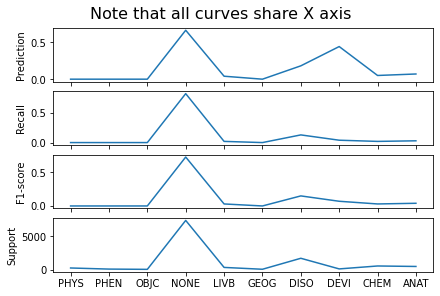

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, axarr = plt.subplots(4, constrained_layout=True, sharex=True)
fig.suptitle('Note that all curves share X axis', fontsize=16)

axarr[0].plot(l, p)
axarr[1].plot(l, r)
axarr[2].plot(l, f)
axarr[3].plot(l, s)
axarr[0].set_ylabel('Prediction')
axarr[1].set_ylabel('Recall')
axarr[2].set_ylabel('F1-score')
axarr[3].set_ylabel('Support')
plt.show()

We can observe that:

- all the curves are sharing the X-axis
- only the curve that appears at the bottom, i.e. the support one, has integer values in the range [0, 7000]. All the other graphic vary between 0 and 1.
- the value at label NONE at the support curve is very much higher than the other values.
- all curves get the higher value at label NONE as we noticed before
- the second higher value at the precision curve is obtained at label GEOG, although the recall value is not so good
- the value at label DISO is the second higher for the support curve as the values for precision, recall and F1 for label DISO are also high

We can assume that there is a certain correlation between the values for the support curve and the values for the other curves. Let's calculate the Pearson correlation between those values.

In [45]:
import pandas as pd

df = pd.DataFrame(np.corrcoef([p,r,f,s]),
                  columns=['precision','recall','F1-score','Support'],
                  index=['precision','recall','F1-score','Support'])
df

,precision,recall,F1-score,Support
precision,1.000000,0.835736,0.859445,0.805240
recall,0.835736,1.000000,0.998064,0.995496
F1-score,0.859445,0.998064,1.000000,0.994388
Support,0.805240,0.995496,0.994388,1.000000


# Issues
- Pulling in data from flat files on disk (will fail when time to move to a bucket)
- Packages missing all over the place (much easier just to add it inline)
- Repeatedly tried to run my notebook, and it turned out i hadn't installed a python package in the environment in which my notebook was running. BUT i had installed a previous version of a library in the system, which was giving me the wrong results. Python/Jupyter helpfully fell back to the system version and i had to tear my hair out
- No automated tests at all for correctness
- Another: The original author wrote a particular output processing based on a libraries function output - but that was all hidden from view - they took the output (as text) and parsed it to move onto the next step. But because the library's version changed, the output changed, and the function no longer worked. But I didn't see why because the output was hidden - so i ended up having to tear apart everything until i figured out why a dict wasn't' being populated correctly
- No parameterization (impossible to mount in external tokens, data sources without changing hard coding)
- No formal output capturing in objects - manual parsing
- No exception handling anywhere - failures will (at best) show stack traces
- Inline debugging via printf statements and/or viewing outputs
- Functions defined all over the place - and hidden local state of the functions (could result in wrong function being executed)
- Use of .pkl to serialize data structures for passing around and/or capturing state